In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, LeaveOneOut
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy
from tqdm import tqdm
from gtfparse import read_gtf

In [2]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

# value_to_predict = 'population'
value_to_predict = 'Age'

organ = "HEART"
# organ = "BRAIN0"
# organ = "BRAIN1"

sex = 'male'
# sex = 'female'

In [3]:
fdir_processed / f'{organ}.preprocessed.h5'

PosixPath('../data/interim/HEART.preprocessed.h5')

In [4]:
gtf_rawdata = read_gtf(fdir_raw / 'all_transcripts_strigtie_merged.gtf')
gtf_data = gtf_rawdata.to_pandas()
gtf_data = gtf_data.set_index('transcript_id')
gtf_data['transcript_id'] = gtf_data.index

gtf_data

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 'ref_gene_id']


,seqname,source,feature,start,end,score,strand,frame,gene_id,exon_number,gene_name,ref_gene_id,transcript_id
transcript_id,,,,,,,,,,,,,
MSTRG.1.1,GL000008.2,StringTie,transcript,1,17013,1000.0,NaN,0,MSTRG.1,,,,MSTRG.1.1
MSTRG.1.1,GL000008.2,StringTie,exon,1,17013,1000.0,NaN,0,MSTRG.1,1,,,MSTRG.1.1
MSTRG.2.1,GL000008.2,StringTie,transcript,199413,199638,1000.0,NaN,0,MSTRG.2,,,,MSTRG.2.1
MSTRG.2.1,GL000008.2,StringTie,exon,199413,199638,1000.0,NaN,0,MSTRG.2,1,,,MSTRG.2.1
MSTRG.3.1,GL000009.2,StringTie,transcript,60101,61775,1000.0,NaN,0,MSTRG.3,,,,MSTRG.3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000711259.1,chrY,HAVANA,exon,57062156,57062405,NaN,+,0,ENSG00000292365.1,1,DPH3P2,,ENST00000711259.1
ENST00000711266.1,chrY,HAVANA,transcript,57165512,57165845,NaN,-,0,ENSG00000292367.1,,ELOCP24,ENSG00000292367.1,ENST00000711266.1
ENST00000711266.1,chrY,HAVANA,exon,57165512,57165845,NaN,-,0,ENSG00000292367.1,1,ELOCP24,,ENST00000711266.1


In [5]:
data = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="data")
data_header = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="header")

data = data.iloc[:, np.argwhere(np.sum(data > 0, axis=0) > 18).ravel()]
# data
if organ == "BRAIN1":
    data_header['sex'] = data_header['gender'] 


data = data.loc[data_header['sex'] == sex]
data_header = data_header.loc[data_header['sex'] == sex]



In [6]:
# eval_organ = "BRAIN0"
# eval_organ = "BRAIN1"
eval_organ = 'HEART'
# eval_organ = organ

fname = next((fdir_external / eval_organ / 'reg').glob("*processed.h5"))
fname = fname.name
data_eval = pd.read_hdf(fdir_external / eval_organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / eval_organ / 'reg' / 'SraRunTable.txt', sep=',')
data_eval_header.set_index("Run", inplace=True)

if eval_organ == "BRAIN1":
    data_eval_header['sex'] = data_eval_header['gender'] 

data_eval_header = data_eval_header.loc[data_eval_header['sex'] == sex]
data_eval = data_eval.loc[(data_eval_header['sex'] == sex).index]


In [7]:
common_transcripts = data.columns.intersection(data_eval.columns)

data_eval = data_eval[common_transcripts]
data = data[common_transcripts]
data

,ENST00000217939.7,ENST00000219919.9,ENST00000225328.10,ENST00000229270.8,ENST00000229384.5,ENST00000254090.9,ENST00000257359.7,ENST00000258646.3,ENST00000262483.13,ENST00000262816.11,...,MSTRG.8936.21,MSTRG.8962.2,MSTRG.8982.1,MSTRG.9001.7,MSTRG.9028.1,MSTRG.9324.5,MSTRG.9679.13,MSTRG.9771.2,MSTRG.9909.7,MSTRG.9947.1
SRR21423865,0.261337,0.700861,0.230293,0.050038,0.173703,0.998828,0.157837,0.465965,0.138334,0.612528,...,0.293984,0.181426,0.229189,0.045588,0.670476,3.122885,0.000000,0.205576,0.157416,1.288009
SRR21423866,0.215134,0.423867,0.614019,7.383792,0.095922,0.750918,0.455461,0.000747,0.345484,0.195109,...,0.403191,0.010333,0.036389,0.082904,0.284415,1.928724,0.065204,0.273387,0.638021,0.478016
SRR21423867,0.262184,0.358779,2.117810,0.698957,0.235107,0.492090,1.090215,0.192674,0.400191,0.103679,...,0.177826,0.318815,0.000000,0.075820,0.052427,0.793868,0.048176,0.029965,0.357537,0.461588
SRR21423868,0.308074,0.059754,0.626421,3.763629,0.125748,0.462030,0.717636,0.667225,0.228899,0.428619,...,0.611195,3.504058,0.316747,0.043994,0.286718,0.892429,0.015543,0.565275,2.066639,0.286413
SRR21423869,0.754179,1.453474,0.142237,0.374044,0.150452,0.575592,2.185232,0.344658,2.321511,0.147737,...,0.714831,1.622228,0.424776,0.107286,3.326561,0.044800,3.532580,0.015273,0.204109,0.000000
SRR21423870,0.146555,0.179128,0.243557,1.732574,0.105178,0.576549,4.078045,0.000547,2.768125,0.063317,...,1.076633,2.949119,0.922589,0.136757,0.232714,1.258804,2.483706,0.277603,0.205321,0.160987
SRR21423871,0.306749,0.353826,0.648142,1.901722,0.151024,3.710600,1.115982,0.754340,0.153399,0.057600,...,0.235962,0.291576,0.074659,2.515296,0.126450,0.160743,0.053291,0.047442,2.917742,0.223282
SRR21423872,0.145591,1.014250,0.170111,1.652357,0.447779,3.593437,0.912620,0.000757,0.203139,0.042249,...,0.319338,0.124030,0.123766,0.049302,0.310305,0.515333,0.018587,1.024719,2.712366,0.128669
SRR21423873,0.115266,0.716922,0.372328,1.736317,0.142043,0.679035,4.318837,0.894486,0.827129,0.033659,...,0.348896,0.034488,1.285657,0.098981,2.720603,0.087250,2.928725,1.581741,0.095159,0.779156


In [8]:
# y = data_header[value_to_predict]
# X = data.values

y = data_header.loc[data_header['sex'] == sex][value_to_predict]
X = data.loc[data_header['sex'] == sex].values
y

SRR21423865    28
SRR21423866    28
SRR21423867    34
SRR21423868    34
SRR21423869    34
SRR21423870    34
SRR21423871    26
SRR21423872    26
SRR21423873    26
Name: Age, dtype: int64

In [9]:
from scipy.stats import spearmanr

rhos = []
pvalues = []

for i in tqdm(range(X.shape[1])):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(X[:, i], y)
    rhos.append(rho)
    pvalues.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)


  0%|          | 0/1608 [00:00<?, ?it/s]

100%|██████████| 1608/1608 [00:01<00:00, 1163.78it/s]


In [10]:
# np.argwhere(np.array(pvalues) < 0.05).shape
unsignificant_corr_ids = np.argwhere(np.array(pvalues) > 0.05)
# unsignificant_corr_ids

rhos = np.array(rhos)
rhos[unsignificant_corr_ids] = 0
rhos[np.argwhere(X.mean(axis=0) == 0)] = 0


In [11]:
corr_threshold = 0.96
corr_threshold = 0.5
corr_threshold = 0.3

if np.abs(rhos).max() > corr_threshold:
    sorted_corr_border = np.argwhere(np.sort(np.abs(rhos))[::-1] > corr_threshold).max()
    sorted_corr_ids = np.argsort(np.abs(rhos))[::-1][:sorted_corr_border]
    # np.sort(np.abs(rhos))[::-1][:sorted_corr_border], sorted_corr_ids
else:
    sorted_corr_ids = []

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129],
 [Text(0, 0, 'ENST00000580063.1'),
  Text(1, 0, 'ENST00000590632.1'),
  Text(2, 0, 'ENST00000565500.5'),
  Text(3, 0, 'ENST00000511757.1'),
  Text(4, 0, 'ENST00000687101.1'),
  Text(5, 0, 'MSTRG.2752

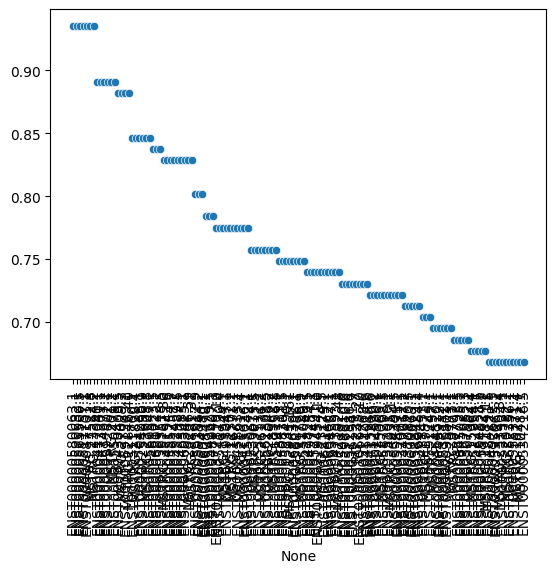

In [12]:
# plt.figure(figsize=(16,6))
sns.scatterplot(
    y=np.abs(rhos[sorted_corr_ids]), 
    x=data.columns[sorted_corr_ids],
    )
plt.xticks(rotation=90)

In [13]:
data.columns[sorted_corr_ids], len(sorted_corr_ids) 

(Index(['ENST00000580063.1', 'ENST00000590632.1', 'ENST00000565500.5',
        'ENST00000511757.1', 'ENST00000687101.1', 'MSTRG.27522.8',
        'MSTRG.23364.2', 'ENST00000417040.1', 'ENST00000473301.1',
        'ENST00000674977.2',
        ...
        'ENST00000492672.5', 'ENST00000595665.1', 'MSTRG.23340.84',
        'ENST00000531334.1', 'MSTRG.20782.2', 'ENST00000652356.1',
        'ENST00000555371.1', 'MSTRG.16771.4', 'MSTRG.10482.1',
        'ENST00000534216.5'],
       dtype='object', length=130),
 130)

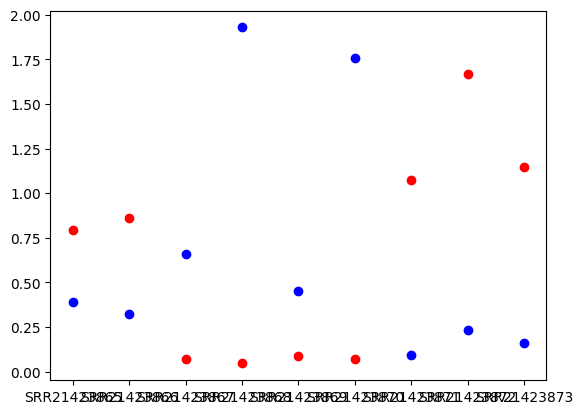

In [14]:
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]], 'bo')
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][1]], 'ro')

In [15]:
data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]]

SRR21423865    0.392636
SRR21423866    0.322279
SRR21423867    0.658244
SRR21423868    1.928241
SRR21423869    0.454345
SRR21423870    1.756046
SRR21423871    0.095738
SRR21423872    0.232243
SRR21423873    0.162615
Name: ENST00000580063.1, dtype: float32

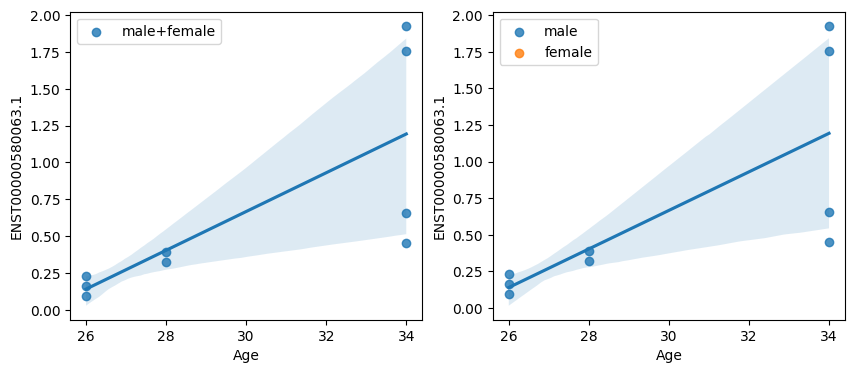

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]], x=data_header['Age'], ax=axs[0], label='male+female')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'male'], x=data_header['Age'].loc[data_header['sex'] == 'male'], ax=axs[1], 
            label='male')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'female'], x=data_header['Age'].loc[data_header['sex'] == 'female'], ax=axs[1], 
            label='female')
axs[0].legend()
axs[1].legend()

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

from sklearn import svm
from xgboost import XGBRegressor


from sklearn.metrics import root_mean_squared_error as RMSE

# n_features = 5
# n_features = -1

# sex = 'male'

print(data.shape[0])

for n_features in range(1, np.min([data.shape[0]+1, len(sorted_corr_ids)+1, 11])):
# for n_features in [5]:

    X = data[data.columns[sorted_corr_ids[:n_features]]].values
    y = data_header['Age'].loc[data_header['sex'] == sex].values

    # print(X.shape)
    print(f"{n_features=}")

    # cv = StratifiedKFold(n_splits=5)
    cv = LeaveOneOut()

    preds = []
    vals  = []
    gls_preds = []

    for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]

        # train_scaler = RobustScaler().fit(X_train)
        # test_scaler = RobustScaler().fit(X_test)
        # X_train = train_scaler.transform(X_train)
        # X_test = test_scaler.transform(X_test)

        X_train_ = X_train
        y_train_ = y_train
        X_val = X_test
        y_val = y_test

        model = svm.SVR(kernel='linear')
        # model = LinearRegression()
        # model = XGBRegressor()
        # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
        #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
        
        model.fit(X_train_, y_train_)
        pred = model.predict(X_test)
        
        preds.append(pred)
        vals.append(y_val)
        
        X_train_ = sm.add_constant(X_train_)
        X_test = sm.add_constant(X_test, has_constant='add')
        
        mod = sm.GLS(y_train_, X_train_).fit()
        gls_pred = mod.predict(X_test)
        gls_preds.append(gls_pred)

    print("RMSE: ", RMSE(preds, vals))
    print("RMSE: ", RMSE(gls_preds, vals))
    print("R2: ", r2_score(vals, preds))
    print("R2: ", r2_score(vals, gls_preds))
    print(data.columns[sorted_corr_ids[:n_features]])
    print("-"*20)
    # print(model.coef_)
    # print(model.intercept_)

    # plt.plot(vals, "bo")
    # plt.plot(preds, "ro")
    # plt.show()
    
model.coef_

9
n_features=1


9it [00:00, 1207.11it/s]


RMSE:  2.880482009765738
RMSE:  2.932443332832609
R2:  0.377711754356195
R2:  0.3550582074794184
Index(['ENST00000580063.1'], dtype='object')
--------------------
n_features=2


9it [00:00, 1248.72it/s]


RMSE:  1.9254869473120115
RMSE:  1.837506994173529
R2:  0.7219375011798304
R2:  0.7467676034772521
Index(['ENST00000580063.1', 'ENST00000590632.1'], dtype='object')
--------------------
n_features=3


9it [00:00, 1195.41it/s]


RMSE:  1.4479479169979759
RMSE:  6.036602372418427
R2:  0.8427585122245917
R2:  -1.733042615201584
Index(['ENST00000580063.1', 'ENST00000590632.1', 'ENST00000565500.5'], dtype='object')
--------------------
n_features=4


9it [00:00, 1283.10it/s]


RMSE:  1.4551460451294045
RMSE:  6.363095906993125
R2:  0.841191249050819
R2:  -2.03667421411945
Index(['ENST00000580063.1', 'ENST00000590632.1', 'ENST00000565500.5',
       'ENST00000511757.1'],
      dtype='object')
--------------------
n_features=5


9it [00:00, 1257.08it/s]


RMSE:  1.475755652133611
RMSE:  4.984935354185857
R2:  0.8366608941396776
R2:  -0.8637185364059052
Index(['ENST00000580063.1', 'ENST00000590632.1', 'ENST00000565500.5',
       'ENST00000511757.1', 'ENST00000687101.1'],
      dtype='object')
--------------------
n_features=6


9it [00:00, 1116.10it/s]


RMSE:  1.51796663433627
RMSE:  8.868386108646838
R2:  0.8271832972781362
R2:  -4.898620412903015
Index(['ENST00000580063.1', 'ENST00000590632.1', 'ENST00000565500.5',
       'ENST00000511757.1', 'ENST00000687101.1', 'MSTRG.27522.8'],
      dtype='object')
--------------------
n_features=7


9it [00:00, 1155.42it/s]


RMSE:  1.092116444382558
RMSE:  5.147443535528968
R2:  0.9105461253931899
R2:  -0.987213121359422
Index(['ENST00000580063.1', 'ENST00000590632.1', 'ENST00000565500.5',
       'ENST00000511757.1', 'ENST00000687101.1', 'MSTRG.27522.8',
       'MSTRG.23364.2'],
      dtype='object')
--------------------
n_features=8


9it [00:00, 1197.04it/s]


RMSE:  0.9776593601955346
RMSE:  13.362489425398179
R2:  0.9283136631566543
R2:  -12.391709273290862
Index(['ENST00000580063.1', 'ENST00000590632.1', 'ENST00000565500.5',
       'ENST00000511757.1', 'ENST00000687101.1', 'MSTRG.27522.8',
       'MSTRG.23364.2', 'ENST00000417040.1'],
      dtype='object')
--------------------
n_features=9


9it [00:00, 1154.54it/s]

RMSE:  0.9810712568026085
RMSE:  13.417792742740938
R2:  0.9278124391806812
R2:  -12.502787156536355
Index(['ENST00000580063.1', 'ENST00000590632.1', 'ENST00000565500.5',
       'ENST00000511757.1', 'ENST00000687101.1', 'MSTRG.27522.8',
       'MSTRG.23364.2', 'ENST00000417040.1', 'ENST00000473301.1'],
      dtype='object')
--------------------


array([[-0.20888732, -1.2222051 , -0.04842515, -0.46028088, -1.20500529,
        -0.17232542,  1.10424853, -0.51346603, -0.08237372]])

In [18]:
n_features = 5

X = data[data.columns[sorted_corr_ids[:n_features]]].values
y = data_header['Age'].loc[data_header['sex'] == sex].values

X_total = X
X_total = RobustScaler().fit_transform(X)

model.fit(X_total, y)
pred = model.predict(X_total)
print(pred)


mod = sm.GLS(y, sm.add_constant(X_total)).fit()
gls_pred = mod.predict(sm.add_constant(X_total))
print(gls_pred)

print("RMSE: ", RMSE(y, pred))
print("RMSE: ", RMSE(y, gls_pred))

print("-"*20)

X_eval = data_eval[data.columns[sorted_corr_ids[:n_features]]]
# X_eval = RobustScaler().fit_transform(X_eval)

y_predicted = model.predict(X_eval)
# print(y_predicted.astype(int), data_eval_header['Age'].values)
# 
y_pred_gls = mod.predict(sm.add_constant(X_eval))
# print(y_pred_gls.astype(int), data_eval_header['Age'].values)

print("RMSE eval: ", RMSE(data_eval_header['Age'].values, y_predicted))
print("RMSE eval: ", RMSE(data_eval_header['Age'].values, y_pred_gls))


print("R2: ", r2_score(data_eval_header['Age'].values, y_predicted))
print("R2: ", r2_score(data_eval_header['Age'].values, y_pred_gls))

# y_predicted = mod.predict(sm.add_constant(X_eval))

[28.07982115 28.09946481 34.10045016 34.10003889 30.06004971 33.85338113
 25.90003945 25.90000649 26.66166945]
[29.24813675 28.15571473 34.13600169 34.19343276 33.25273898 33.71516511
 26.26311583 25.54851394 25.48718022]
RMSE:  1.3349517403088056
RMSE:  0.559125188819783
--------------------
RMSE eval:  2.346229077997489
RMSE eval:  6.890735704621807
R2:  0.587140683516929
R2:  -2.561167891321235


/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


In [19]:
transcripts = data.columns[sorted_corr_ids[:n_features]]
print(transcripts.values)
print(model.coef_)
gtf_data.loc[transcripts].drop_duplicates()

['ENST00000580063.1' 'ENST00000590632.1' 'ENST00000565500.5'
 'ENST00000511757.1' 'ENST00000687101.1']
[[ 1.33944252 -0.97848766  0.69327947 -0.18403155 -0.24124783]]


,seqname,source,feature,start,end,score,strand,frame,gene_id,exon_number,gene_name,ref_gene_id,transcript_id
ENST00000580063.1,chr17,StringTie,transcript,63830682,63831616,1000.0,+,0,MSTRG.15655,,PSMC5,ENSG00000087191.14,ENST00000580063.1
ENST00000580063.1,chr17,StringTie,exon,63830682,63830935,1000.0,+,0,MSTRG.15655,1,PSMC5,ENSG00000087191.14,ENST00000580063.1
ENST00000580063.1,chr17,StringTie,exon,63831036,63831226,1000.0,+,0,MSTRG.15655,2,PSMC5,ENSG00000087191.14,ENST00000580063.1
ENST00000580063.1,chr17,StringTie,exon,63831327,63831425,1000.0,+,0,MSTRG.15655,3,PSMC5,ENSG00000087191.14,ENST00000580063.1
ENST00000580063.1,chr17,StringTie,exon,63831506,63831616,1000.0,+,0,MSTRG.15655,4,PSMC5,ENSG00000087191.14,ENST00000580063.1
ENST00000590632.1,chr19,StringTie,transcript,10393085,10393786,1000.0,-,0,MSTRG.17184,,CDC37,ENSG00000105401.9,ENST00000590632.1
ENST00000590632.1,chr19,StringTie,exon,10393085,10393157,1000.0,-,0,MSTRG.17184,1,CDC37,ENSG00000105401.9,ENST00000590632.1
ENST00000590632.1,chr19,StringTie,exon,10393259,10393786,1000.0,-,0,MSTRG.17184,2,CDC37,ENSG00000105401.9,ENST00000590632.1
ENST00000565500.5,chr15,StringTie,transcript,42415123,42448705,1000.0,-,0,MSTRG.11457,,ZNF106,ENSG00000103994.18,ENST00000565500.5
ENST00000565500.5,chr15,StringTie,exon,42415123,42417360,1000.0,-,0,MSTRG.11457,1,ZNF106,ENSG00000103994.18,ENST00000565500.5


In [20]:
gtf_data.loc[transcripts, 'gene_name'].drop_duplicates().values

array(['PSMC5', 'CDC37', 'ZNF106', 'SLC25A36', 'CWC27'], dtype=object)

In [21]:
# from ucsc.api import Hub, Genome, Track, TrackSchema, Chromosome, Sequence

# genome = Genome.find('wuhCor1')

# print(genome.genomeName)
# print(genome.organism)
# print(genome.__dict__) # to return all attributes in the object

# track = genome.tracks[0]

# ---------------------------------

# # track = genome.findTrackBy('shortLabel','Microdeletions')
# # (dir(track))
# # sequence = Sequence.get(genome='hg38', chrom='chr1')
# # sequence.dna

# genome = Genome.find('hg38')
# tracks = genome.tracks

# for track in tracks:
#     print(track.trackName)

In [22]:
import requests, json
headers = {"accept": "application/json"}

genes_dict = {}

for gene_name in gtf_data.loc[transcripts, 'gene_name'].drop_duplicates().values: 
    print(f"{gene_name=}")
    url = f"https://www.encodeproject.org/search/?searchTerm={gene_name}"
    
    response = requests.get(url, headers=headers)
    search_results = response.json()
    
    for result in search_results["@graph"]:
        if "organism" in result.keys():
            if (result['organism']['scientific_name'] == 'Homo sapiens'):
                if "name" in result.keys():
                    print(result['name'])
                    print(result['title'])
                    print(result['geneid'])
                    print("-"*10)
                    genes_dict[gene_name] = result
                    break
        else:
            print(result)
            

    # print(search_results["@graph"])

gene_name='PSMC5'
PSMC5-human
PSMC5 (Homo sapiens)


KeyError: 'geneid'

In [ ]:
for key in genes_dict.keys():
    print(genes_dict[key]['geneid'])

121456
107105267
401331
170384
100507102


In [ ]:
from Bio import Entrez


In [ ]:
Entrez.email = "zodelheim@gmail.com"
handle = Entrez.einfo() # or esearch, efetch, ...
record = Entrez.read(handle)
handle.close()
record


{'DbList': ['pubmed', 'protein', 'nuccore', 'ipg', 'nucleotide', 'structure', 'genome', 'annotinfo', 'assembly', 'bioproject', 'biosample', 'blastdbinfo', 'books', 'cdd', 'clinvar', 'gap', 'gapplus', 'grasp', 'dbvar', 'gene', 'gds', 'geoprofiles', 'medgen', 'mesh', 'nlmcatalog', 'omim', 'orgtrack', 'pmc', 'popset', 'proteinclusters', 'pcassay', 'protfam', 'pccompound', 'pcsubstance', 'seqannot', 'snp', 'sra', 'taxonomy', 'biocollections', 'gtr']}

In [ ]:
for key in genes_dict.keys():
    print(genes_dict[key]['geneid'])
    handle = Entrez.efetch(db="gene", id=str(genes_dict[key]['geneid']), retmode='xml')
    records = Entrez.parse(handle)
    for record in records:
        if "Entrezgene_summary" in record.keys():
            print(record['Entrezgene_summary'])
        # each record is a Python dictionary or list.
        # print(record.keys())
        print(record['Entrezgene_type'])
        print(key)
        print("-"*10)

    handle.close()

121456
7
SLC9A7P1
----------
107105267
7
MTCO1P2
----------
401331
7
RASA4
----------
170384
Predicted to enable alpha-(1->3)-fucosyltransferase activity. Predicted to be involved in fucosylation. Predicted to be located in Golgi cisterna membrane. Predicted to be integral component of membrane. [provided by Alliance of Genome Resources, Apr 2022]
6
FUT11
----------
100507102
7
COX20P1
----------


In [ ]:
genes_dict['SLC9A7P1']

{'@id': '/genes/121456/',
 '@type': ['Gene', 'Item'],
 'dbxrefs': ['HGNC:32679', 'ENSEMBL:ENSG00000227825', 'RefSeq:NR_033801.1'],
 'geneid': '121456',
 'name': 'solute carrier family 9 member 7 pseudogene 1',
 'organism': {'scientific_name': 'Homo sapiens'},
 'status': 'released',
 'symbol': 'SLC9A7P1',
 'title': 'SLC9A7P1 (Homo sapiens)'}

In [ ]:
# record['Entrezgene_summary']
print(record.keys())
# record['Entrezgene_comments']
# genes_dict[key]['geneid']

dict_keys(['Entrezgene_track-info', 'Entrezgene_type', 'Entrezgene_source', 'Entrezgene_gene', 'Entrezgene_location', 'Entrezgene_gene-source', 'Entrezgene_locus', 'Entrezgene_properties', 'Entrezgene_comments', 'Entrezgene_unique-keys', 'Entrezgene_xtra-index-terms'])


In [ ]:
handle = Entrez.esearch(db='gene', term='PACS2')
records = Entrez.read(handle)
handle.close()

In [ ]:
records['IdList']

['1956', '156110', '7534', '7186', '8850', '10971', '5311', '330', '7529', '329', '637', '7532', '10551', '7533', '259266', '26277', '22627', '55948', '10474', '55690']